In [1]:
library(tidycensus)
library(tidyverse)
library(sf)
library(ggmap)
library(viridis)
library(tmaptools)
library(tigris)
library(leaflet)
# library(mapview)
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to GEOS 3.9.0, GDAL 3.2.2, PROJ 7.2.1; sf_use_s2() is TRUE

ℹ Google's Terms of Service: <https://mapsplatform.google.com>
  Stadia Maps' Terms of Service: <https://stadiamaps.com/terms-of-service/>
  OpenStreetMap's Tile Usage Policy: <https://operations.osmfoundation.org/policies/tiles/>
ℹ Please cite ggmap if you use it! Use `citation("ggmap")` for details.
Loading required package: viridisLite

To enable caching of data, set `options(tigris_use_cache = TRUE)`


In [3]:
# Load CENSUS_API_KEY and STADIAMAPS_API_KEY
readRenviron(".env")
register_stadiamaps(key = Sys.getenv("STADIAMAPS_API_KEY"))

# Worcester

## Load Data

In [19]:
vars <- load_variables(2020,"acs5/subject")

vars %>%
    filter(
        grepl("percent occupied housing.*vehicle", tolower(vars$label))
        & grepl("S2504", vars$name, fixed=TRUE)
    )

# vars$name

name,label,concept
<chr>,<chr>,<chr>
S2504_C02_027,Estimate!!Percent occupied housing units!!Occupied housing units!!VEHICLES AVAILABLE!!No vehicle available,PHYSICAL HOUSING CHARACTERISTICS FOR OCCUPIED HOUSING UNITS
S2504_C02_028,Estimate!!Percent occupied housing units!!Occupied housing units!!VEHICLES AVAILABLE!!1 vehicle available,PHYSICAL HOUSING CHARACTERISTICS FOR OCCUPIED HOUSING UNITS
S2504_C02_029,Estimate!!Percent occupied housing units!!Occupied housing units!!VEHICLES AVAILABLE!!2 vehicles available,PHYSICAL HOUSING CHARACTERISTICS FOR OCCUPIED HOUSING UNITS
S2504_C02_030,Estimate!!Percent occupied housing units!!Occupied housing units!!VEHICLES AVAILABLE!!3 or more vehicles available,PHYSICAL HOUSING CHARACTERISTICS FOR OCCUPIED HOUSING UNITS


In [20]:
wo_tract_df <- get_acs(
    state = "MA",
    county = "Worcester County",
    geography = "tract",
    variables =
        # "S2504_C02_030"
        c(percent_no_car="S2504_C02_027",
          percent_one_car="S2504_C02_028",
          percent_two_cars="S2504_C02_029",
          percent_three_cars="S2504_C02_030")
        ,
    geometry = TRUE
)

Getting data from the 2018-2022 5-year ACS

Using the ACS Subject Tables



In [31]:
# Aggregate in avg. number of cars per tract

wo_grouped_tract_df <- wo_tract_df %>%
    mutate(
        num_cars = as.numeric(case_when(
            variable=="percent_no_car" ~ "0",
            variable=="percent_one_car" ~ "1",
            variable=="percent_two_cars" ~ "2",
            variable=="percent_three_cars" ~ "3"
        ))
    ) %>%
    group_by(GEOID,NAME) %>%
    summarise(avg_num_cars = sum(num_cars * estimate/100))

head(wo_grouped_tract_df)

`summarise()` has grouped output by 'GEOID'. You can override using the
`.groups` argument.


GEOID,NAME,avg_num_cars,geometry
<chr>,<chr>,<dbl>,<POLYGON [°]>
25027700100,Census Tract 7001; Worcester County; Massachusetts,2.068,POLYGON ((-71.98611 42.6277...
25027701101,Census Tract 7011.01; Worcester County; Massachusetts,1.986,POLYGON ((-72.08083 42.6384...
25027701102,Census Tract 7011.02; Worcester County; Massachusetts,1.613,POLYGON ((-72.06762 42.6761...
25027702201,Census Tract 7022.01; Worcester County; Massachusetts,2.110,POLYGON ((-72.27196 42.6746...
25027702202,Census Tract 7022.02; Worcester County; Massachusetts,1.766,POLYGON ((-72.11663 42.6266...
25027703100,Census Tract 7031; Worcester County; Massachusetts,1.578,POLYGON ((-72.27666 42.5704...


## Load WRTA Data

In [22]:
wrta_folder = "rta-gtfs-files/unzipped-files/wrta-ma-us"

### Route shapes

In [23]:
wrta_lines_df = read_csv(file.path(wrta_folder,"shapes.txt"))
head(wrta_lines_df)

Rows: 100363 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): shape_id
dbl (4): shape_pt_lat, shape_pt_lon, shape_pt_sequence, shape_dist_traveled

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
shp-1-03,42.23400,-71.79041,1,0.00
shp-1-03,42.23404,-71.79036,2,0.01
shp-1-03,42.23394,-71.79022,3,16.03
shp-1-03,42.23385,-71.79011,4,29.53
shp-1-03,42.23378,-71.79002,5,40.28
shp-1-03,42.23371,-71.78993,6,51.03


### Route details

In [46]:
wrta_routes_df <- read_csv(file.path(wrta_folder,"routes.txt"))
head(wrta_routes_df)

Rows: 27 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): route_id, route_short_name, route_long_name, route_url, route_color...
dbl (3): agency_id, route_type, route_sort_order
lgl (1): route_desc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


agency_id,route_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order
<dbl>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,1,1,Mount St. Ann via Providence St.,NA,3,http://www.therta.com/routes/1/,6c64c4,ffffff,1
1,2,2,Tatnuck Square via Pleasant St.,NA,3,http://www.therta.com/routes/2/,da05fb,000000,2
1,3,3,Worcester State University via Highland St.,NA,3,http://www.therta.com/routes/3/,ff8704,000000,3
1,4,4,The Shoppes at Blackstone Valley via Millbury St.,NA,3,http://www.therta.com/routes/4/,f5270b,000000,4
1,5,5,Southwest Commons via Grafton St.,NA,3,http://www.therta.com/routes/5/,00da42,000000,5
1,6,6,West Tatnuck via Chandler St.,NA,3,http://www.therta.com/routes/6/,3100ff,ffffff,6


### Trip details

In [32]:
wrta_trips_df <- read_csv(file.path(wrta_folder,"trips.txt"))
head(wrta_trips_df)

Rows: 3227 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): trip_headsign, shape_id
dbl (7): trip_id, route_id, service_id, direction_id, block_id, wheelchair_a...
lgl (1): trip_short_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


trip_id,route_id,service_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1834020,1,1,ROUTE 146 + WALMART >> HUB CENTER,NA,1,2509802,shp-1-03,0,0
1976060,1,4,ROUTE 146 + WALMART >> HUB CENTER,NA,1,2509906,shp-1-03,0,0
654010,1,2,ROUTE 146 + WALMART >> HUB CENTER,NA,1,2506801,shp-1-03,0,0
1314010,1,2,ROUTE 146 + WALMART >> HUB CENTER,NA,1,2506801,shp-1-03,0,0
466090,1,3,ROUTE 146 + WALMART >> HUB CENTER,NA,1,2526809,shp-1-03,0,0
1834060,1,4,ROUTE 146 + WALMART >> HUB CENTER,NA,1,2509806,shp-1-03,0,0


In [33]:
# Right now we are only interested in the core WRTA bus lines, so we will only use the numbered ones.
unique(wrta_trips_df$route_id)

[1]   1  11  12  14  15  16  19   2  23  24  26  27  29   3  30  31  33   4  42
[20]   5   6   7 825

In [34]:
wrta_trips_df <- wrta_trips_df %>%
    filter(grepl("[[:digit:]]",route_id))

#### Removing multiple shapes per route

`summarise()` has grouped output by 'route_id'. You can override using the
`.groups` argument.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


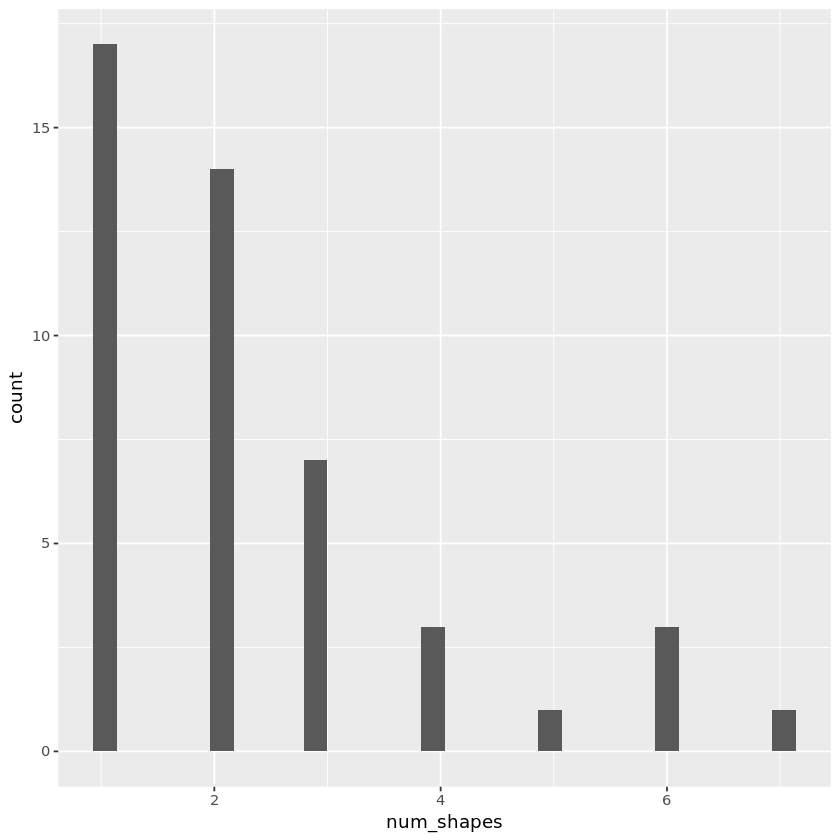

In [35]:
wrta_trips_df %>%
    group_by(route_id, direction_id) %>%
    summarise(num_shapes=n_distinct(shape_id)) %>%
    ggplot(aes(x=num_shapes)) +
        geom_histogram()

Above we see that there are multiple route shapes per route. We should try to remove the extras.

In [48]:
# Get the distance per shape
shape_dist <- wrta_lines_df %>%
    group_by(shape_id) %>%
    summarise(max_dist = max(shape_dist_traveled))

# Select the longest shapes per route
distinct_route_shape_id <- wrta_trips_df %>%
    distinct(route_id, trip_headsign, direction_id, shape_id) %>%
    inner_join(shape_dist, by=join_by(shape_id)) %>%
    group_by(route_id, direction_id) %>%
    mutate(rank=rank(-max_dist)) %>%
    filter(rank==1) %>%
    as_tibble()

# Get the shapes for each `shape_id`
distinct_route_shapes <- distinct_route_shape_id %>%
    dplyr::select(route_id, shape_id, trip_headsign) %>%
    inner_join(wrta_lines_df, by=join_by(shape_id)) %>%
    mutate(across(route_id, as.character)) %>%
    inner_join(wrta_routes_df[,c("route_id","route_color")], by=join_by(route_id))

# Get distinct shape ids and colors
shape_id_colors <- distinct_route_shapes %>%
    dplyr::select(shape_id, route_color) %>%
    distinct()

head(distinct_route_shapes)

route_id,shape_id,trip_headsign,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,route_color
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,shp-1-03,ROUTE 146 + WALMART >> HUB CENTER,42.23400,-71.79041,1,0.00,6c64c4
1,shp-1-03,ROUTE 146 + WALMART >> HUB CENTER,42.23404,-71.79036,2,0.01,6c64c4
1,shp-1-03,ROUTE 146 + WALMART >> HUB CENTER,42.23394,-71.79022,3,16.03,6c64c4
1,shp-1-03,ROUTE 146 + WALMART >> HUB CENTER,42.23385,-71.79011,4,29.53,6c64c4
1,shp-1-03,ROUTE 146 + WALMART >> HUB CENTER,42.23378,-71.79002,5,40.28,6c64c4
1,shp-1-03,ROUTE 146 + WALMART >> HUB CENTER,42.23371,-71.78993,6,51.03,6c64c4


#### Test route shapes

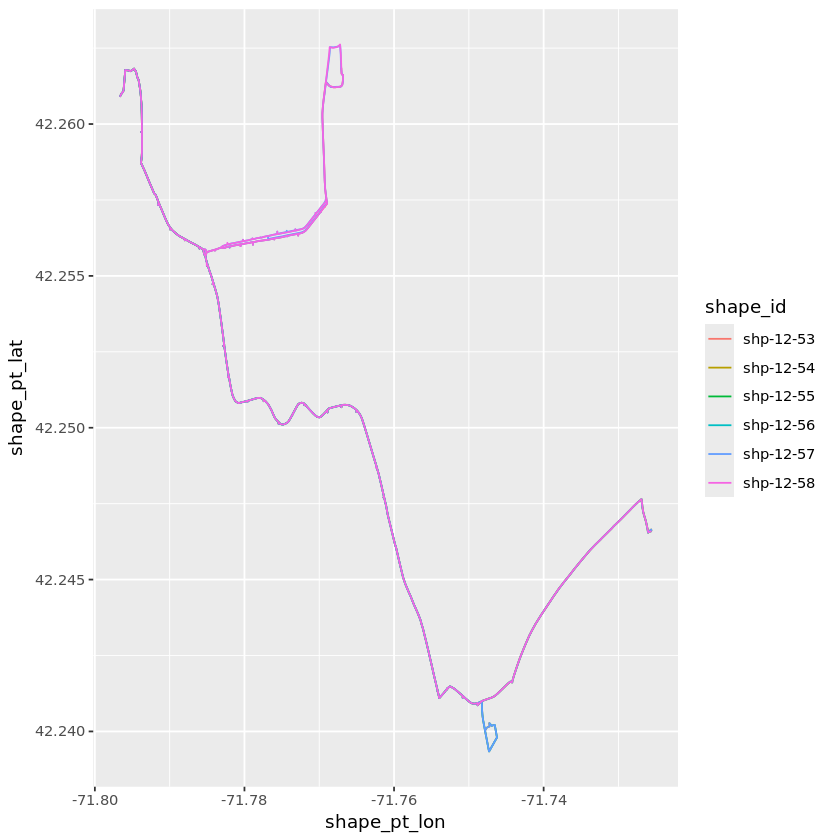

In [49]:
ggplot(
    data=wrta_lines_df %>%
        filter(grepl("shp-12-5[3-8]", shape_id)),
    aes(y=shape_pt_lat, x=shape_pt_lon, col=shape_id), alpha=0.1
) +
    geom_path()

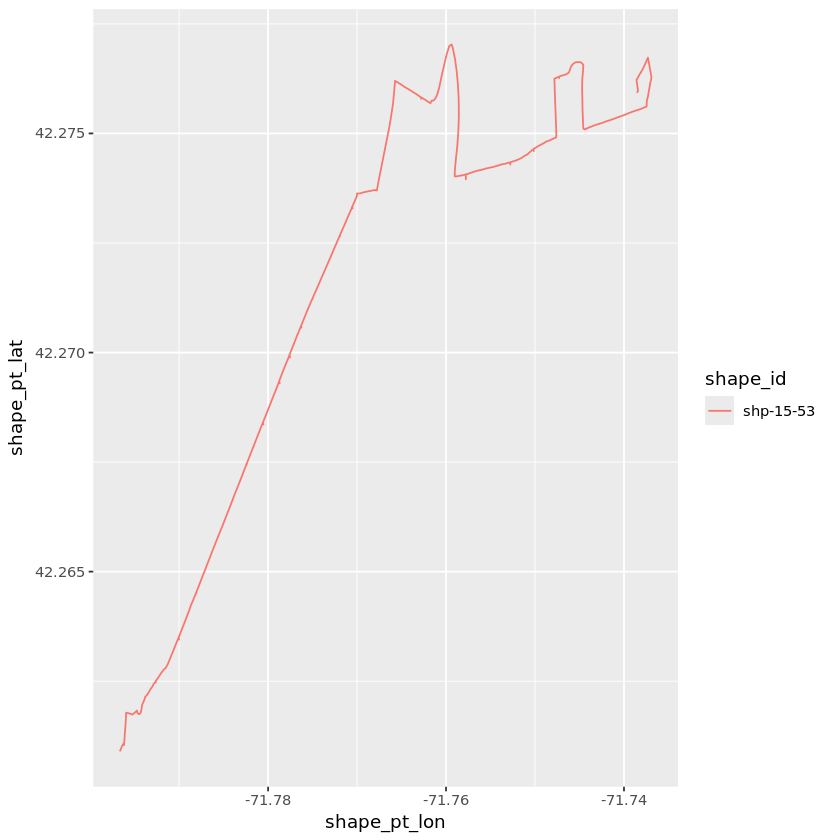

In [50]:
ggplot(
    data=wrta_lines_df %>%
        filter(grepl("shp-15-5[23]", shape_id)),
    aes(y=shape_pt_lat, x=shape_pt_lon, col=shape_id), alpha=0.1
) +
    geom_path()

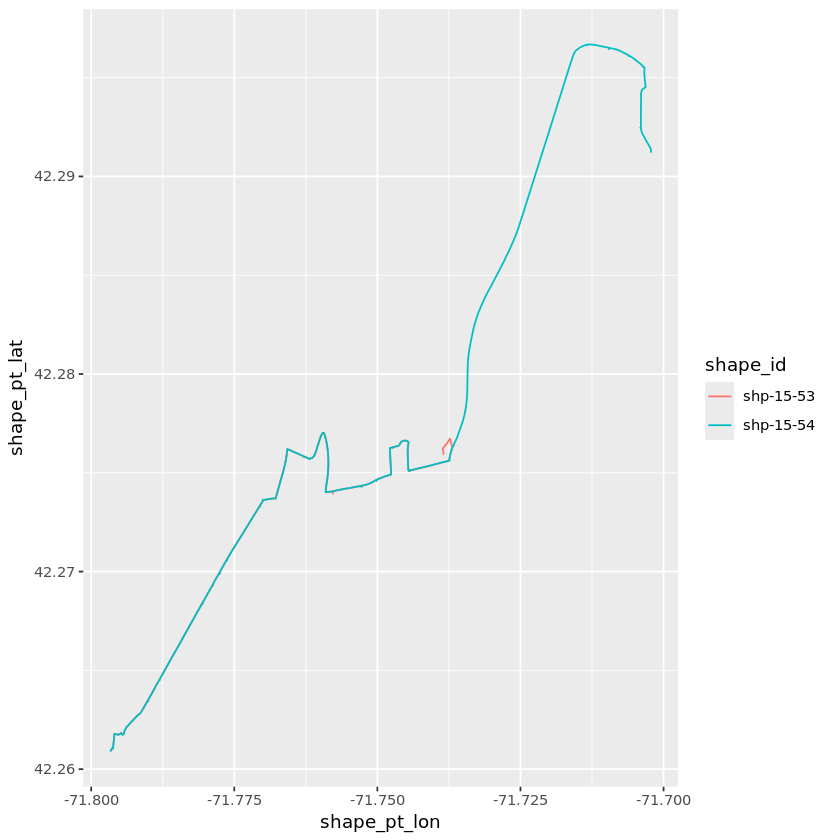

In [51]:
ggplot(
    data=wrta_lines_df %>%
        filter(grepl("shp-15-5[34]", shape_id)),
    aes(y=shape_pt_lat, x=shape_pt_lon, col=shape_id), alpha=0.1
) +
    geom_path()

## Make Maps

In [52]:
# Get Worcester map
big_worcester_map=get_stadiamap(
    bbox=c('left'=-72.11, 'bottom'=42.0, 'right'=-71.55,'top'=42.37),zoom=11,
    maptype="stamen_toner_lite",
    color="color"
)

ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.



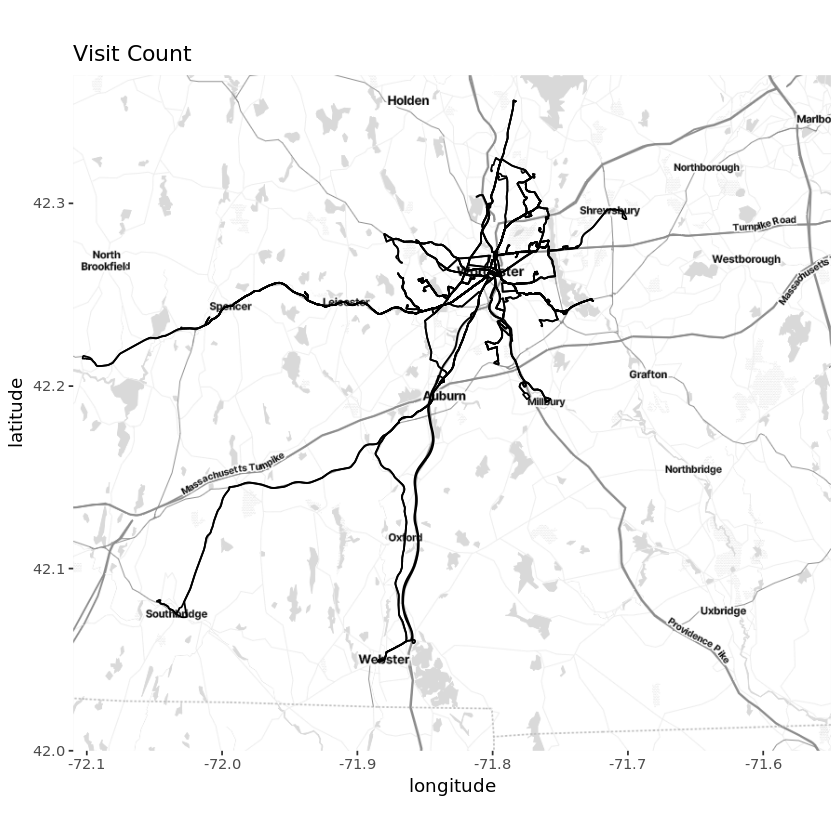

In [53]:
ggmap(big_worcester_map) +
  geom_path(aes(x = shape_pt_lon, y = shape_pt_lat, group=shape_id),
             data = wrta_lines_df,
           show.legend=FALSE)+
  labs(title="Visit Count",x ="longitude", y = "latitude")

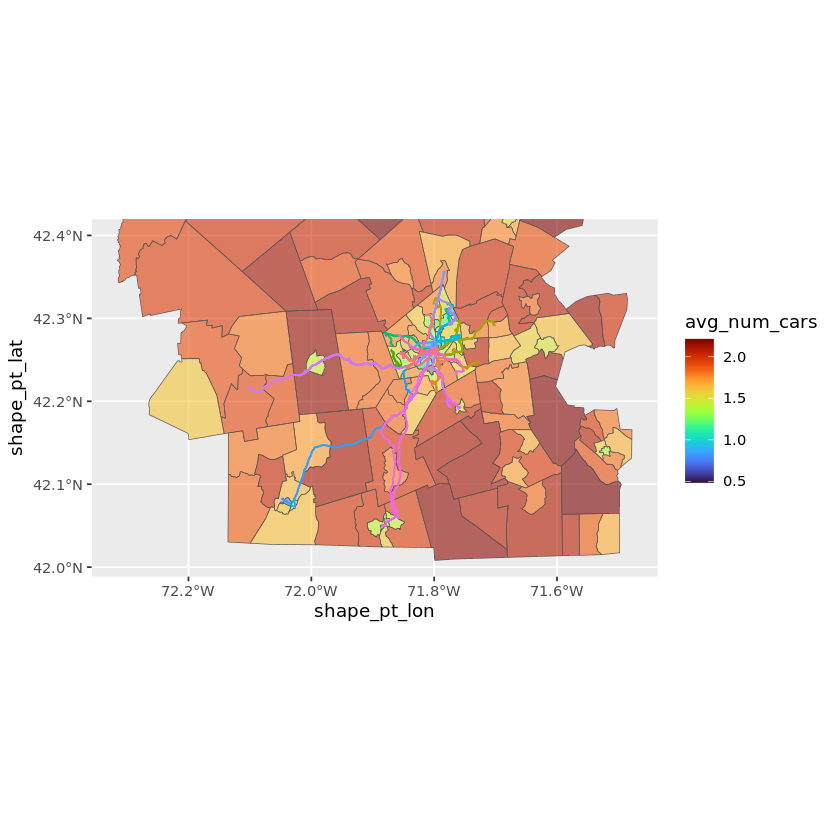

In [54]:
ggplot() +
  geom_sf(wo_grouped_tract_df, mapping=aes(fill = avg_num_cars),alpha=0.6) +
  coord_sf(crs = 4269) +
  scale_fill_viridis(option = "turbo") +
  geom_path(aes(x = shape_pt_lon, y = shape_pt_lat, col=shape_id),
             data = wrta_lines_df,
           show.legend=FALSE)+
  ylim(NA, 42.4)

### Map with tracts, streets, and WRTA lines

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Saving 6.67 x 6.67 in image


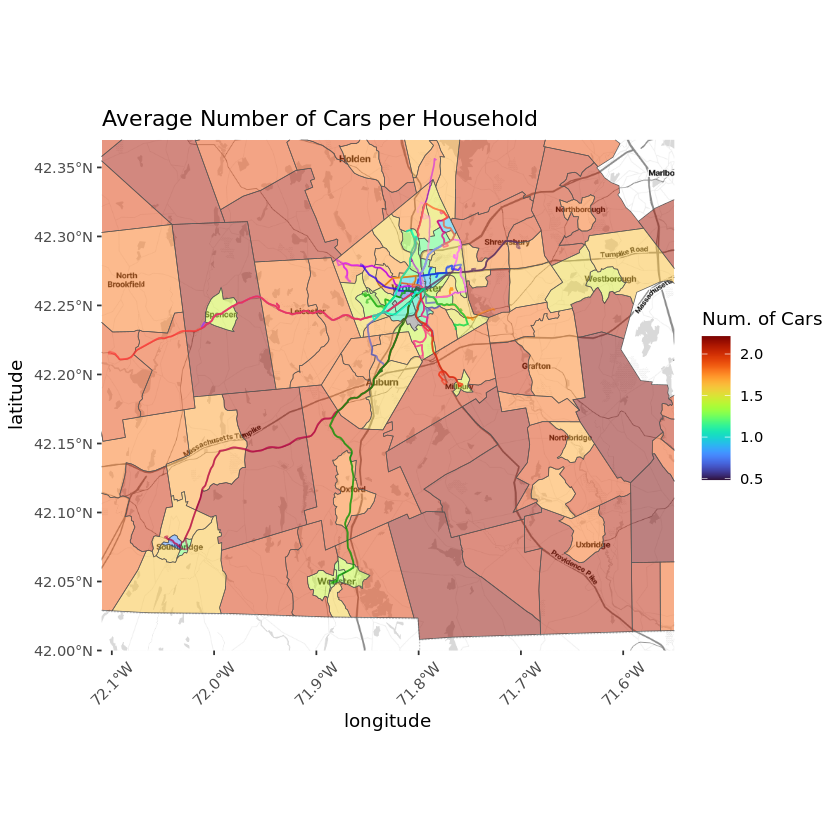

In [76]:
# Set WRTA line colors
group.colors <- setNames(paste("#",shape_id_colors$route_color,sep=""),shape_id_colors$shape_id)

worcester_county_map <- ggmap(big_worcester_map) +
    geom_sf(
      wo_grouped_tract_df,
      mapping=aes(fill = avg_num_cars),
      alpha=0.5,
      inherit.aes = FALSE
         ) +
  scale_fill_viridis(option = "turbo") +
  geom_path(
      data = distinct_route_shapes,
      aes(x = shape_pt_lon, y = shape_pt_lat, col=shape_id),
      show.legend=FALSE,
      alpha=0.5
  )+
  scale_color_manual(values=group.colors)+
  labs(
      title="Average Number of Cars per Household",
      x ="longitude",
      y = "latitude",
      fill="Num. of Cars"
  ) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5))

ggsave("worcester_country_car_ownership.png", plot=worcester_county_map)

worcester_county_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Saving 6.67 x 6.67 in image


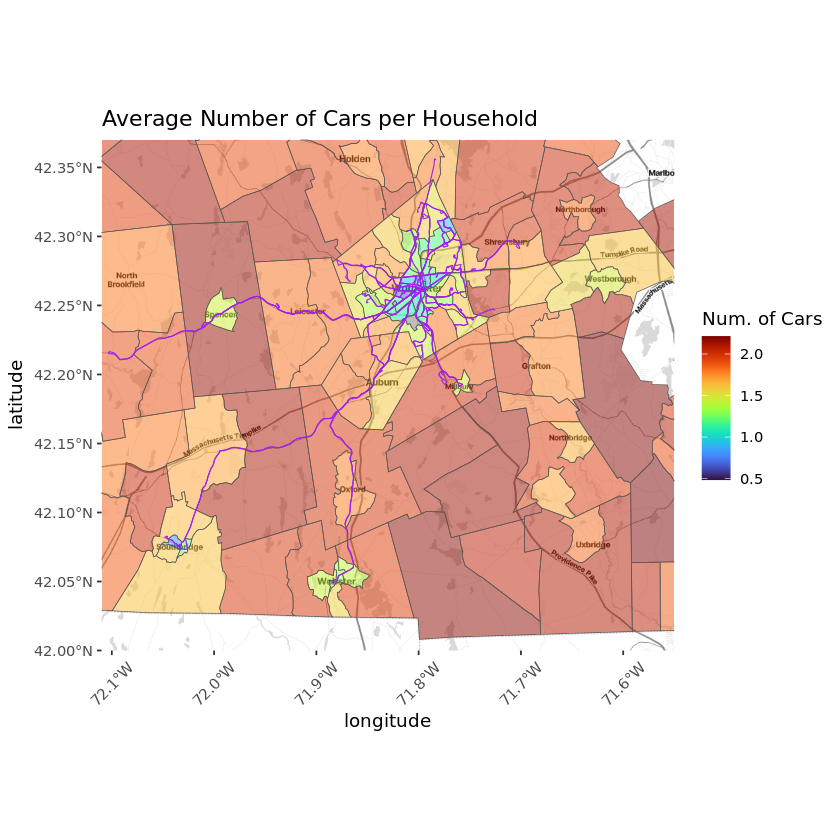

In [77]:
same_color_worcester_county_map <- ggmap(big_worcester_map) +
    geom_sf(
      wo_grouped_tract_df,
      mapping=aes(fill = avg_num_cars),
      alpha=0.5,
      inherit.aes = FALSE
         ) +
  scale_fill_viridis(option = "turbo") +
  geom_path(
      data = distinct_route_shapes,
      aes(x = shape_pt_lon, y = shape_pt_lat, group=shape_id),
      color="purple",
      show.legend=FALSE,
      linewidth=0.3
  )+
  labs(
      title="Average Number of Cars per Household",
      x ="longitude",
      y = "latitude",
      fill="Num. of Cars"
  ) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5))

ggsave("worcester_country_car_ownership_same_color.png", plot=same_color_worcester_county_map,dpi=500)

same_color_worcester_county_map

### Map zommed in on Worcester

In [78]:
zoomed_worcester_map <- get_stadiamap(
    bbox=c('left'=-71.9, 'bottom'=42.15, 'right'=-71.72,'top'=42.35),zoom=12,
    maptype="stamen_toner_lite",
    color="color"
)

ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.



Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Saving 6.67 x 6.67 in image
Warning message:
“Removed 10113 rows containing missing values or values outside the scale range
(`geom_path()`).”
Warning message:
“Removed 10113 rows containing missing values or values outside the scale range
(`geom_path()`).”


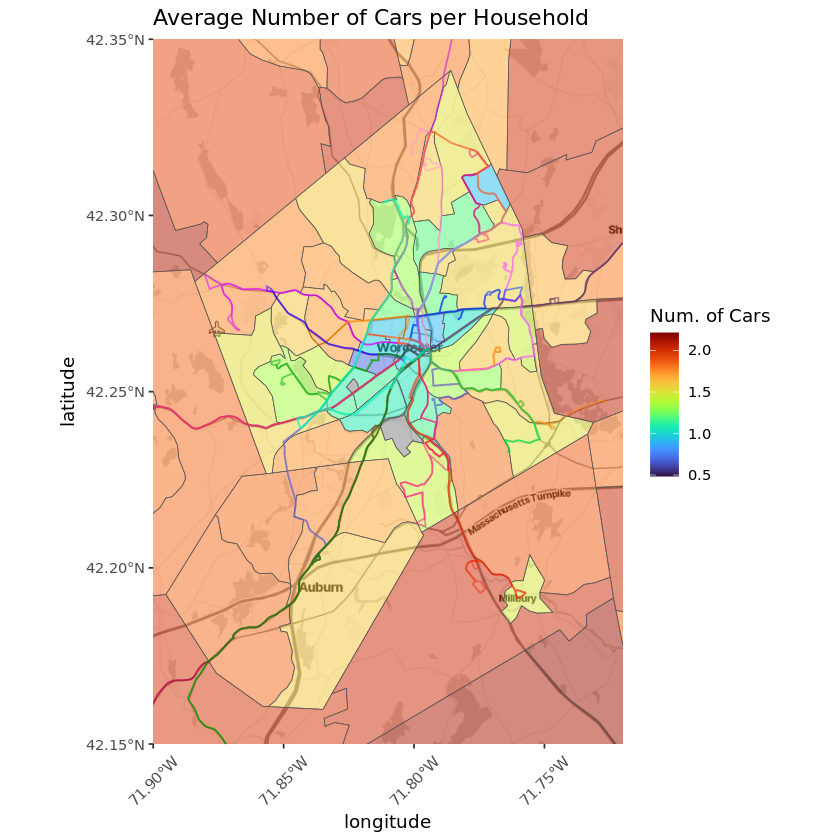

In [79]:
# Set WRTA line colors
group.colors <- setNames(paste("#",shape_id_colors$route_color,sep=""),shape_id_colors$shape_id)

zoomed_map <- ggmap(zoomed_worcester_map) +
  geom_sf(
      wo_grouped_tract_df,
      mapping=aes(fill = avg_num_cars),
      alpha=0.5,
      inherit.aes = FALSE
         ) +
  scale_fill_viridis(option = "turbo") +
  geom_path(
      data = distinct_route_shapes,
      aes(x = shape_pt_lon, y = shape_pt_lat, col=shape_id),
      show.legend=FALSE,
      alpha=0.5
  )+
  scale_color_manual(values=group.colors)+
  labs(
      title="Average Number of Cars per Household",
      x ="longitude",
      y = "latitude",
      fill="Num. of Cars"
  ) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5))

# plot_ratio <- get_asp_ratio(wo_grouped_tract_df$geometry)
ggsave("worcester_city_car_ownership.png", plot=zoomed_map)

zoomed_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Saving 6.67 x 6.67 in image
Warning message:
“Removed 10113 rows containing missing values or values outside the scale range
(`geom_path()`).”
Warning message:
“Removed 10113 rows containing missing values or values outside the scale range
(`geom_path()`).”


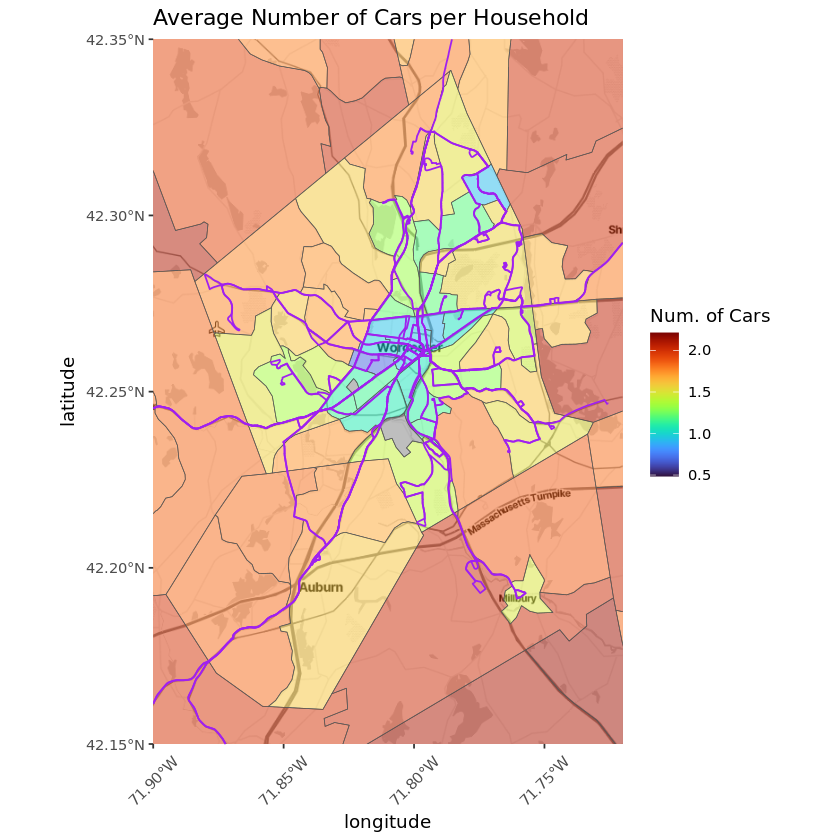

In [80]:
# All lines the same color

same_color_lines_zoomed_map <- ggmap(zoomed_worcester_map) +
  geom_sf(
      wo_grouped_tract_df,
      mapping=aes(fill = avg_num_cars),
      alpha=0.5,
      inherit.aes = FALSE
         ) +
  scale_fill_viridis(option = "turbo") +
  geom_path(
      data = distinct_route_shapes,
      aes(x = shape_pt_lon, y = shape_pt_lat, group=shape_id),
      color="purple",
      show.legend=FALSE,
      linewidth=0.5
  )+
  labs(
      title="Average Number of Cars per Household",
      x ="longitude",
      y = "latitude",
      fill="Num. of Cars"
  ) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5))

ggsave("worcester_city_car_ownership_same_color.png", plot=same_color_lines_zoomed_map)

same_color_lines_zoomed_map

# MetroWest

## Load Data

### Get Census Data

In [81]:
# Middlesex county

get_county_car_ownership <- function(county) {
    temp  <- get_acs(
        state = "MA",
        county = county,
        geography = "tract",
        variables =
            # "S2504_C02_030"
            c(percent_no_car="S2504_C02_027",
              percent_one_car="S2504_C02_028",
              percent_two_cars="S2504_C02_029",
              percent_three_cars="S2504_C02_030")
            ,
        geometry = TRUE
    )

    return (temp)
}


all_mw_counties_df <- get_county_car_ownership("Middlesex County") %>%
    bind_rows(get_county_car_ownership("Norfolk County")) %>%
    bind_rows(get_county_car_ownership("Worcester County"))

head(all_mw_counties_df)

Getting data from the 2018-2022 5-year ACS

Using the ACS Subject Tables

Getting data from the 2018-2022 5-year ACS

Using the ACS Subject Tables

Getting data from the 2018-2022 5-year ACS

Using the ACS Subject Tables



,GEOID,NAME,variable,estimate,moe,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,25017350400,Census Tract 3504; Middlesex County; Massachusetts,percent_no_car,14.8,5.4,MULTIPOLYGON (((-71.1209 42...
2,25017350400,Census Tract 3504; Middlesex County; Massachusetts,percent_one_car,45.2,8.4,MULTIPOLYGON (((-71.1209 42...
3,25017350400,Census Tract 3504; Middlesex County; Massachusetts,percent_two_cars,30.9,8.3,MULTIPOLYGON (((-71.1209 42...
4,25017350400,Census Tract 3504; Middlesex County; Massachusetts,percent_three_cars,9.1,3.1,MULTIPOLYGON (((-71.1209 42...
5,25017350900,Census Tract 3509; Middlesex County; Massachusetts,percent_no_car,25.6,6.1,MULTIPOLYGON (((-71.12772 4...
6,25017350900,Census Tract 3509; Middlesex County; Massachusetts,percent_one_car,45.6,7.4,MULTIPOLYGON (((-71.12772 4...


### Load MWRTA Data

In [82]:
mwrta_folder = "rta-gtfs-files/unzipped-files/mwrta"

In [83]:
mwrta_lines_df = read_csv(file.path(mwrta_folder,"shapes.txt")) %>%
    arrange(shape_id,shape_pt_sequence)

head(mwrta_lines_df)

Rows: 4002 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): shape_id
dbl (4): shape_pt_lat, shape_pt_lon, shape_pt_sequence, shape_dist_traveled

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
00f1a51a-4734-4f85-8bbf-cff01ab55a88,42.30062,-71.35023,0,0.00
00f1a51a-4734-4f85-8bbf-cff01ab55a88,42.30149,-71.34573,1,382.94
00f1a51a-4734-4f85-8bbf-cff01ab55a88,42.29883,-71.34621,2,681.80
00f1a51a-4734-4f85-8bbf-cff01ab55a88,42.29797,-71.34780,3,843.71
00f1a51a-4734-4f85-8bbf-cff01ab55a88,42.29079,-71.34827,4,1641.96
00f1a51a-4734-4f85-8bbf-cff01ab55a88,42.28545,-71.34776,5,2237.04


#### Select only tracts within MWRTA

In [84]:
# Set x and y limits for the plot, then make the points an sf object,
# set the crs as the same for my_rivers
ylims <- c(min(mwrta_lines_df$shape_pt_lat),
           max(mwrta_lines_df$shape_pt_lat)
          )
xlims <- c(min(mwrta_lines_df$shape_pt_lon),
           max(mwrta_lines_df$shape_pt_lon)
          )
box_coords <- tibble(x = xlims, y = ylims) %>%
  st_as_sf(coords = c("x", "y")) %>%
  st_set_crs(st_crs(all_mw_counties_df))

#get the bounding box of the two x & y coordintates, make sfc
bounding_box <- st_bbox(box_coords) %>% st_as_sfc()

# Filter
mw_tracts_df <- all_mw_counties_df %>%
    st_filter(bounding_box, .predicate=st_intersects)

head(mw_tracts_df)

,GEOID,NAME,variable,estimate,moe,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,25017368600,Census Tract 3686; Middlesex County; Massachusetts,percent_no_car,5.5,4.1,MULTIPOLYGON (((-71.25293 4...
2,25017368600,Census Tract 3686; Middlesex County; Massachusetts,percent_one_car,38.7,8.1,MULTIPOLYGON (((-71.25293 4...
3,25017368600,Census Tract 3686; Middlesex County; Massachusetts,percent_two_cars,45.0,9.3,MULTIPOLYGON (((-71.25293 4...
4,25017368600,Census Tract 3686; Middlesex County; Massachusetts,percent_three_cars,10.8,6.1,MULTIPOLYGON (((-71.25293 4...
5,25017980000,Census Tract 9800; Middlesex County; Massachusetts,percent_no_car,NA,NA,MULTIPOLYGON (((-71.49661 4...
6,25017980000,Census Tract 9800; Middlesex County; Massachusetts,percent_one_car,NA,NA,MULTIPOLYGON (((-71.49661 4...


In [85]:
# Aggregate MetroWest tracts

mw_agg_tracts_df <- mw_tracts_df %>%
    mutate(
        num_cars = as.numeric(case_when(
            variable=="percent_no_car" ~ "0",
            variable=="percent_one_car" ~ "1",
            variable=="percent_two_cars" ~ "2",
            variable=="percent_three_cars" ~ "3"
        ))
    ) %>%
    group_by(GEOID,NAME) %>%
    summarise(avg_num_cars = sum(num_cars * estimate/100))

head(mw_agg_tracts_df)

`summarise()` has grouped output by 'GEOID'. You can override using the
`.groups` argument.


GEOID,NAME,avg_num_cars,geometry
<chr>,<chr>,<dbl>,<POLYGON [°]>
25017320102,Census Tract 3201.02; Middlesex County; Massachusetts,2.016,POLYGON ((-71.60222 42.2181...
25017320105,Census Tract 3201.05; Middlesex County; Massachusetts,1.976,POLYGON ((-71.56338 42.2625...
25017320106,Census Tract 3201.06; Middlesex County; Massachusetts,2.114,"POLYGON ((-71.54996 42.221,..."
25017320107,Census Tract 3201.07; Middlesex County; Massachusetts,1.919,POLYGON ((-71.52131 42.2450...
25017321100,Census Tract 3211; Middlesex County; Massachusetts,1.561,POLYGON ((-71.53059 42.3522...
25017321200,Census Tract 3212; Middlesex County; Massachusetts,1.712,POLYGON ((-71.54348 42.3452...


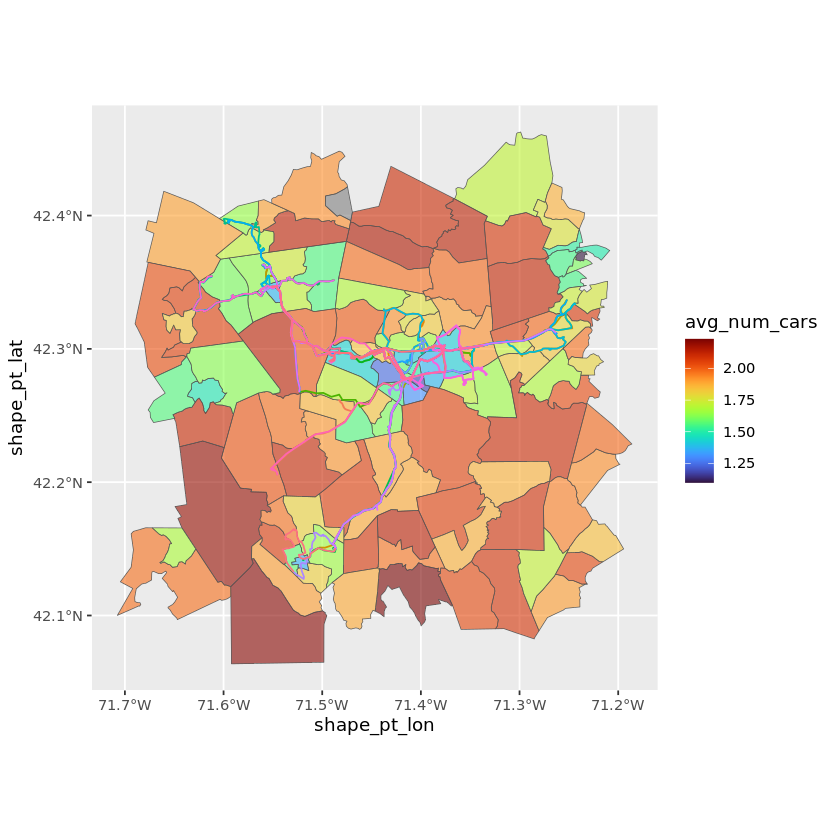

In [86]:
ggplot() +
  geom_sf(mw_agg_tracts_df, mapping=aes(fill = avg_num_cars),alpha=0.6) +
  coord_sf(crs = 4269) +
  scale_fill_viridis(option = "turbo") +
  geom_path(aes(x = shape_pt_lon, y = shape_pt_lat, col=shape_id),
             data = mwrta_lines_df,
           show.legend=FALSE)

### Test route shapes

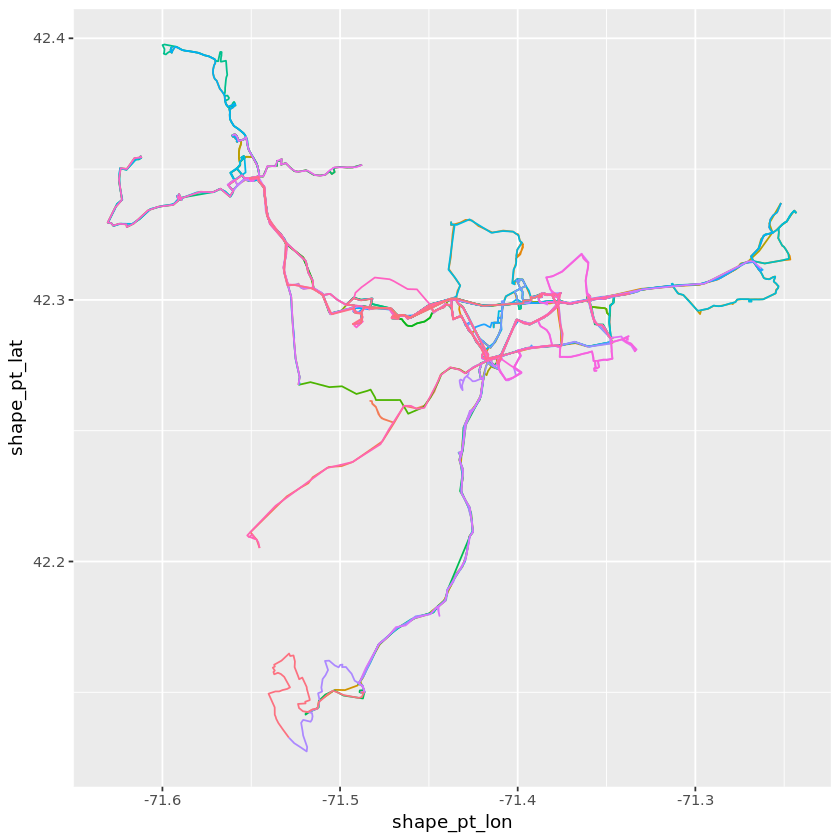

In [87]:
ggplot(
    data=mwrta_lines_df %>% arrange(shape_id,shape_pt_sequence),
    aes(y=shape_pt_lat, x=shape_pt_lon, col=shape_id), alpha=0.1
) +
    geom_path(show.legend=FALSE)


## Make Maps

In [88]:
# Get MetroWest map
big_metrowest_map=get_stadiamap(
    bbox=c('left'=-71.64, 'bottom'=42.11, 'right'=-71.23,'top'=42.41),zoom=11,
    maptype="stamen_toner_lite",
    color="color"
)

ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.



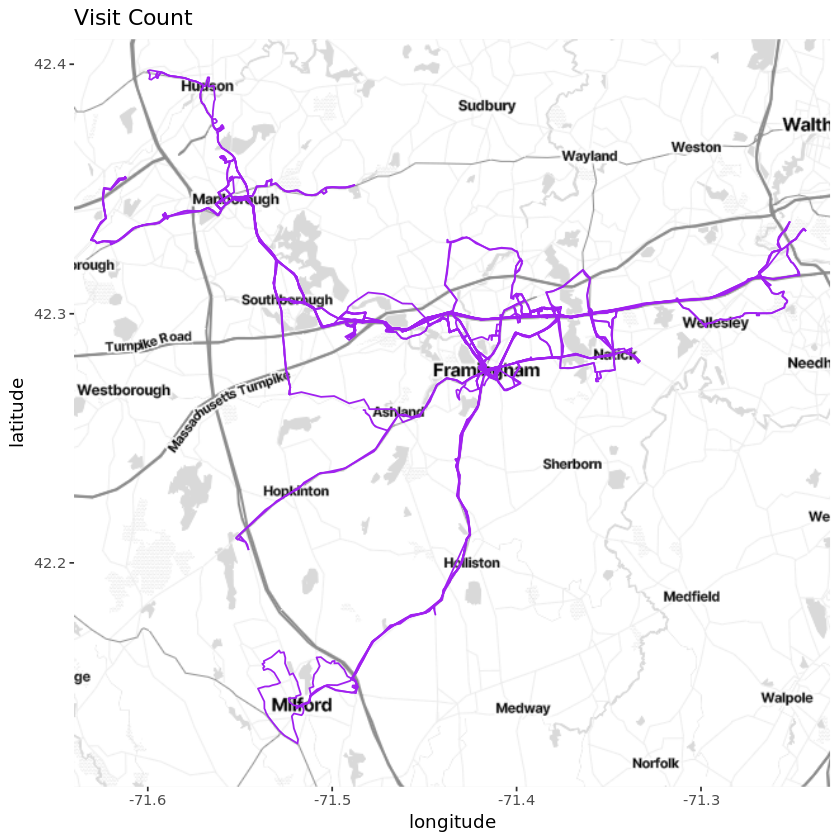

In [89]:
ggmap(big_metrowest_map) +
  geom_path(aes(x = shape_pt_lon, y = shape_pt_lat, group=shape_id),
            data = mwrta_lines_df,
            show.legend=FALSE,
            color = "purple"
           )+
  labs(title="Visit Count",x ="longitude", y = "latitude")

## Map with tracts and MWRTA lines

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Saving 6.67 x 6.67 in image


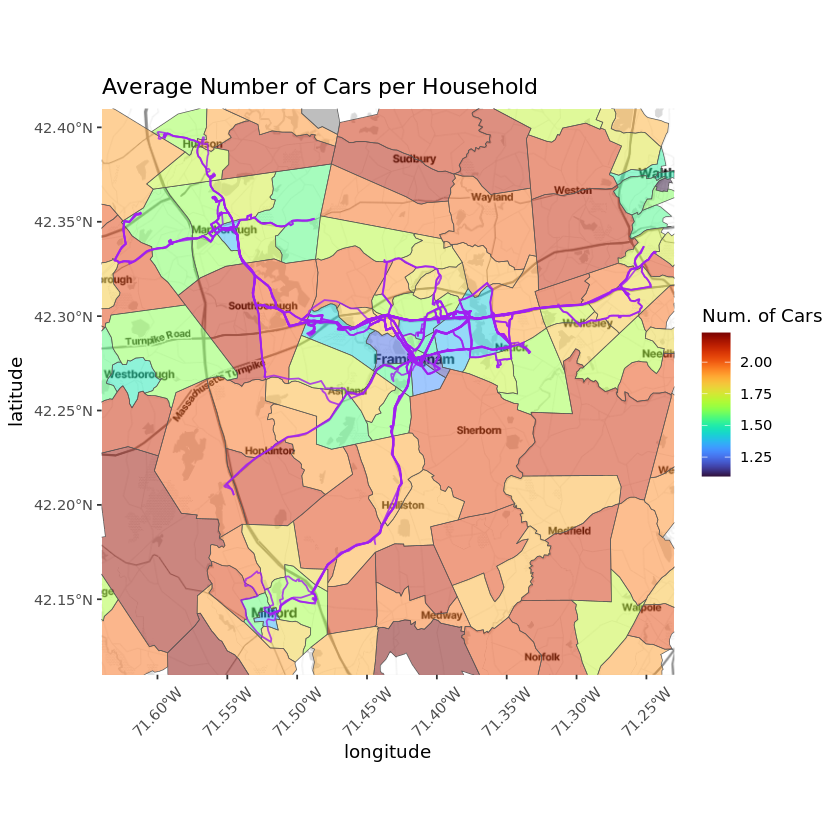

In [92]:
metrowest_big_map <- ggmap(big_metrowest_map) +
    geom_sf(
      mw_agg_tracts_df,
      mapping=aes(fill = avg_num_cars),
      alpha=0.5,
      inherit.aes = FALSE
         ) +
  scale_fill_viridis(option = "turbo") +
  geom_path(
      data = mwrta_lines_df,
      aes(x = shape_pt_lon, y = shape_pt_lat, group=shape_id),
      show.legend=FALSE,
      alpha=0.8,
      linewidth=0.5,
      color="purple"
  )+
  labs(
      title="Average Number of Cars per Household",
      x ="longitude",
      y = "latitude",
      fill="Num. of Cars"
  ) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5))

ggsave("metrowest_big_car_ownership.png", plot=metrowest_big_map, dpi=400)

metrowest_big_map

# Future ideas

* Calculate the relationship of number of cars given income.
    * Plot the residual of avg. number of expected cars given income

* Try interactive map to be able to zoom in and examine each tract

* Calculate number of stops in each tract vs avg. num. cars owned
    * https://gis.stackexchange.com/questions/397917/sf-package-point-in-polygon

* Do same thing but with commuting data

* Try to control for income
    * Num. cars per $10k in income

* Plot income vs transit

* Income vs number of stops
    * Identify communities with fewer stops that they "should"